In [149]:
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from torch import nn
from torch.optim import AdamW, SGD
import torch

# Define model

In [2]:
checkpoint = "distilbert-base-uncased"

In [3]:
class Lambda(nn.Module):
    """A neural network layer that applies the specified function to its inputs."""
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [4]:
def print_shape(x):
    print(x.shape)
    return x

def flatten(x):
    return x.view(x.shape[0], -1)

In [211]:
class RegressiveTransformer(nn.Module):
    TRANSFORMER_HIDDEN_SIZE = 768
    LINEAR_HIDDEN_SIZE = 500
    
    def __init__(self, num_tokens):
        super(RegressiveTransformer, self).__init__()
        self.base_model = AutoModel.from_pretrained(checkpoint)
        self.head = nn.Sequential(
            nn.Linear(self.TRANSFORMER_HIDDEN_SIZE, self.LINEAR_HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(self.LINEAR_HIDDEN_SIZE, 1),
            Lambda(flatten),
            nn.Linear(num_tokens, 1),
            Lambda(flatten),
            Lambda(lambda x: x.squeeze())
        )
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        outputs = self.head(outputs[0])
        return outputs
    
    def freeze_base(self, freeze=True):
        for param in self.base_model.parameters():
            param.requires_grad = not freeze

# Test Model

In [6]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "Left left left",
    "Right right right",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")

In [7]:
inputs

{'input_ids': tensor([[ 101, 2187, 2187, 2187,  102],
        [ 101, 2157, 2157, 2157,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])}

In [8]:
num_tokens = inputs['input_ids'].shape[1]

In [9]:
inputs['input_ids'].shape

torch.Size([2, 5])

In [10]:
model = RegressiveTransformer(num_tokens)

outputs = model(**inputs)
print(outputs)
print(outputs.size())

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([-0.2009, -0.2052], grad_fn=<SqueezeBackward0>)
torch.Size([2])


Alright, we started with a batch of our sentence inputs, and we now have a continuous value for each.

Next, we need some data to fine tune on.

# Data

- Alright, we have a csv with all this data
- We also need to bring in the media bias ratings

- Then we want a way to read from the CSV and generate as much training data as we want
- Let's look at some of the other data sets to look at the rough size that you'd use to finetune BERT
  - Looks like 10-100k rows

- I could preprocess this into a new CSV file with all the info condensed
- Validation set should include articles from publications not in the train set
- Evaluate accuracy based on whether predicted result is within delta of labelled value
  - Maybe delta starts pretty large, say 0.5 or 0.25

What data set do we need to establish the pipeline?

CSV of article => rating

# Read data

In [11]:
import pandas as pd

In [12]:
articles = pd.read_csv('data/trial.csv')

In [52]:
sequences = list(articles.title + ' ' + articles.article)
ratings = torch.tensor(articles.rating).float()

In [53]:
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")

In [54]:
batch

{'input_ids': tensor([[ 101, 2516, 2187, 3720, 2187,  102,    0,    0,    0,    0],
        [ 101, 2516, 8155, 1011, 2187, 3720, 8155, 1011, 2187,  102],
        [ 101, 2516, 2415, 3720, 2415,  102,    0,    0,    0,    0],
        [ 101, 2516, 8155, 1011, 2157, 3720, 8155, 1011, 2157,  102],
        [ 101, 2516, 2157, 3720, 2157,  102,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}

In [55]:
num_tokens = batch['input_ids'].shape[1]

In [212]:
model = RegressiveTransformer(num_tokens)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [213]:
model.freeze_base()

In [218]:
#optimizer = AdamW(model.parameters(), lr=0.0001)
optimizer = SGD(model.parameters(), lr=0.00001)

In [215]:
all_results = []

In [221]:
for i in range(100):
    results = model(**batch)
    all_results.append(results.tolist())
    loss = model.loss(results, ratings)
    loss.backward()
    optimizer.step()

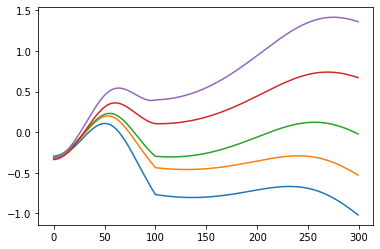

In [222]:
import matplotlib.pyplot as plt
plt.plot(all_results)
plt.show()

In [223]:
model(**batch)

tensor([-1.0290, -0.5360, -0.0274,  0.6680,  1.3564],
       grad_fn=<SqueezeBackward0>)